This will employ the same bump attractor as dynamic_bump_working.ipynb and will demonstrate how dopamine allows a network to be more resistant to noise. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [93]:
class attractor:
    def __init__(self, n_units, exc_spread=1, inp_scale=1, exc_scale = 1, inh_scale = 1, dop_scale = 1,tonic_inhib = 0, n_noise_scale = 0, t_noise_scale = 0):
        
        #number of units in the line
        self.n_units = n_units

        #the input weight matrix just scales the input up or down, allows for adjusting of excitation while still using intuitive inputs (I think)
        self.W_input = np.identity(n_units) * inp_scale

        #generates the internal excitatory weight matrix, exc_spread controls how far excitatory connections reach, exc_scale controls how strong the excitatory connections are
        #its just a collections of Gaussians, exc_spread controls the sd
        self.W_exc = np.zeros((n_units,n_units))
        unit_ids = np.arange(0,n_units,1)        
        for i in range(0,n_units):
            ###the multiplying by n_units is because it is a pdf that decreases with the number of units involved, there might be a smarter way around this 
            ###but not using a pdf does not work so I will keep moving for now, either way I am not sure it makes a difference
            self.W_exc[i] = stats.norm.pdf(unit_ids, i, exc_spread) * n_units * exc_scale
        
        #there is tonic inhibition that scales with the total amount of activity in the network, similar to the basal ganglia
        self.W_inh = np.ones((n_units,n_units)) * (-1 * inh_scale)

        #the dopamine modulates the excitatory current, this is how strong the modulation is
        self.dop_scale = dop_scale

        #how strong the tonic inhibition is, negativly modulated by dopamine
        self.tonic_inhib = tonic_inhib

        #how strong the noise in the neuron's activation is
        self.n_noise_scale = n_noise_scale

        #how strong the noise in the tapping is (there will be some taps that are produced faster or slower then intended by a few milliseconds)
        self.t_noise_scale = t_noise_scale
        
        '''
        #just plotting the weights so they can be checked
        plt.figure(1)
        plt.imshow(self.W_exc, cmap="plasma")
        plt.colorbar()
        plt.title("W_exc matrix")

        plt.figure(2)
        plt.plot(self.W_exc[int(np.round(n_units/2,0))], color="steelblue")
        plt.title("Excitatory weights from unit "+str(int(np.round(n_units/2,0)))+" to all other units")
        plt.xlabel("Unit Number")
        plt.ylabel("Connection Strength")
        '''
        #just initializing these variables so I don't cause mistakes later due to not knowing how to code
        self.dopamine = 0
        self.input = 0
        self.simulation = 0        


    #simulates the attractor receiving the input 
    def run(self, dopamine,means):

        #number of time points and time constant
        n_steps = len(dopamine)
        dt = 0.001
        tau = 0.1
        unit_ids = np.arange(0,200,1) #this is used to define the input to the attractor later


        #storing these for later
        self.dopamine = dopamine
        #matrix to store the input to the attractor
        self.a_input = np.zeros((self.n_units, n_steps))

        #matrix to hold the activations of all the units
        activations = np.zeros((self.n_units, n_steps))
        

        for i in range(0, n_steps-600):
            #now we need to set the new input to the bump attractor, I do not think we need to make it noisy, because there is already the Gaussin representing uncertainty but this can be changed easily
            self.a_input[:,i] = stats.norm.pdf(unit_ids, 500 - 400 + means[i],15)
            #simulate the behavior of the bump attractor
            activations[:,i+1] = activations[:,i] + dt * (1/tau)*(self.non_lin(np.matmul((self.W_input,self.a_input[:,i])+ np.matmul(self.W_exc,activations[:,i]) * self.dop_scale) * dopamine[i] + np.matmul(self.W_inh,activations[:,i]) - (1-dopamine[i]) * self.tonic_inhib) - activations[:,i] + np.random.uniform(low=-1,high=1,size=self.n_units) * self.n_noise_scale)


        self.activations = activations 

        self.saliences = np.zeros(n_steps)
        for i in range(n_steps):
            self.saliences[i] = (np.argmax(activations[:,i]) + 400)/1000

        '''
        plt.figure(3)
        plt.imshow(self.a_input,aspect="auto")
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.colorbar()
        plt.title("Input")

        plt.figure(4)
        plt.imshow(activations,aspect="auto")
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.title("Activations of all units")

        

        self.saliences = np.zeros(n_steps)
        for i in range(n_steps):
            self.saliences[i] = (np.argmax(activations[:,i]) + 400)/1000
        plt.figure(7)
        plt.plot(self.saliences[1:95000])
        plt.ylabel("most salient intertap interval")
        plt.xlabel("time")

        

        #commenting these figures out for now, they are just adding clutter
        
        
        plt.figure(5)
        plt.title("activations of various units")
        for i in range(10):
            x = random.randint(0,self.n_units-1)
            plt.plot(activations[x], label="unit "+str(x), alpha=0.5)
        plt.legend()
        
        
        plt.figure(10)
        plt.title("Activations at certain steps")
        plt.plot(activations[:,int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/4))))
        plt.plot(activations[:,6500],label=str("Activations at time point "+str(int(n_steps/2))))
        plt.plot(activations[:,int(n_steps/2)+int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/2)+int(n_steps/4))))
        plt.plot(activations[:,int(n_steps-1)],label=str("Activations at time point "+str(int(n_steps-1))))
        plt.ylabel("activation")
        plt.xlabel("unit")
        #plt.legend()
        '''
        

    
    def non_lin(self, vec):
        
        vec = np.tanh(vec)
        for i in range(0,len(vec)):
            if vec[i] < 0:
                vec[i] = 0

        return vec

In [94]:
#I am going to try to simulate a Ornstein-Uhlenbeck (?) process, I think it makes a good model for a wandering cortical representation of the most salient rythym
def UO(steps):
    N = steps   #time steps
    kappa = 0.3 #mean revision constant
    theta = 0 #long term mean
    sigma = 0.5 #volatility constant (how much noise there is?)

    dt = 0.001

    X= np.zeros(N)
    X[0] = 0

    W = stats.norm.rvs(loc=0, scale=1, size=(N - 1, 1)) #W is the Wiener process, I think this is just the actual random noise

    std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    for t in range(0, N - 1):
        X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]
    return X

In [95]:
stable = attractor(n_units = 200, exc_spread = 15, inp_scale = 18, exc_scale = 0.03, inh_scale = 1.2, dop_scale = 8, tonic_inhib=5, n_noise_scale= 0.00)
#give the network some time to warm-up before we start adding noise
means = np.concatenate((np.zeros(3000),UO(17000)*10)) 
#dopamine starts to tail off after the network can warm up
dopamine = np.ones(20000)
dopamine[3000:] = np.linspace(1,0.9,17000)

stable.run(dopamine=dopamine,means=means)


C:\Users\Jacob\AppData\Local\Temp\ipykernel_15268\2069297289.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]


Let's run the above noisy simulation like 100 times because it is hard to distinguish the variability from the randomness and from the dopamine

In [88]:
steps = 20000
#matrix to store all of our results
results = np.zeros((100,steps)) #100 x steps

dopamine = np.ones(20000)
dopamine[3000:] = np.linspace(1,0.9,17000)

for i in range(0,100):
    #generate random noise
    noise = UO(steps-3000)
    noise = np.concatenate((np.zeros(3000),noise))

    stable.run(dopamine=dopamine,means=noise)
    
    results[i] = stable.saliences

    

C:\Users\Jacob\AppData\Local\Temp\ipykernel_15268\2069297289.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[t + 1] = theta + np.exp(-kappa * dt) * (X[t] - theta) + std_dt * W[t]


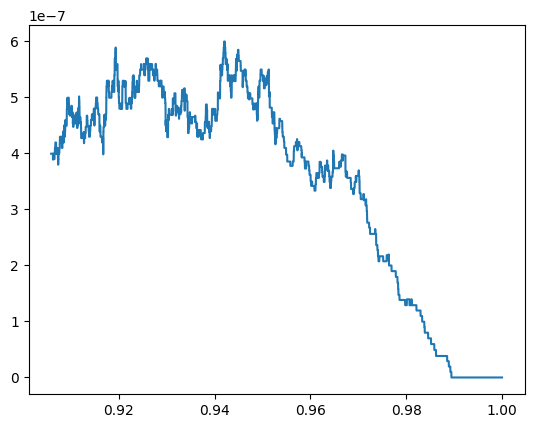

In [91]:
vars = np.var(results,axis=0)

plt.plot(dopamine[3000:19000],vars[3000:19000])
#plt.plot(vars[3000:19000])